In [3]:
pip install  rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 107.3 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


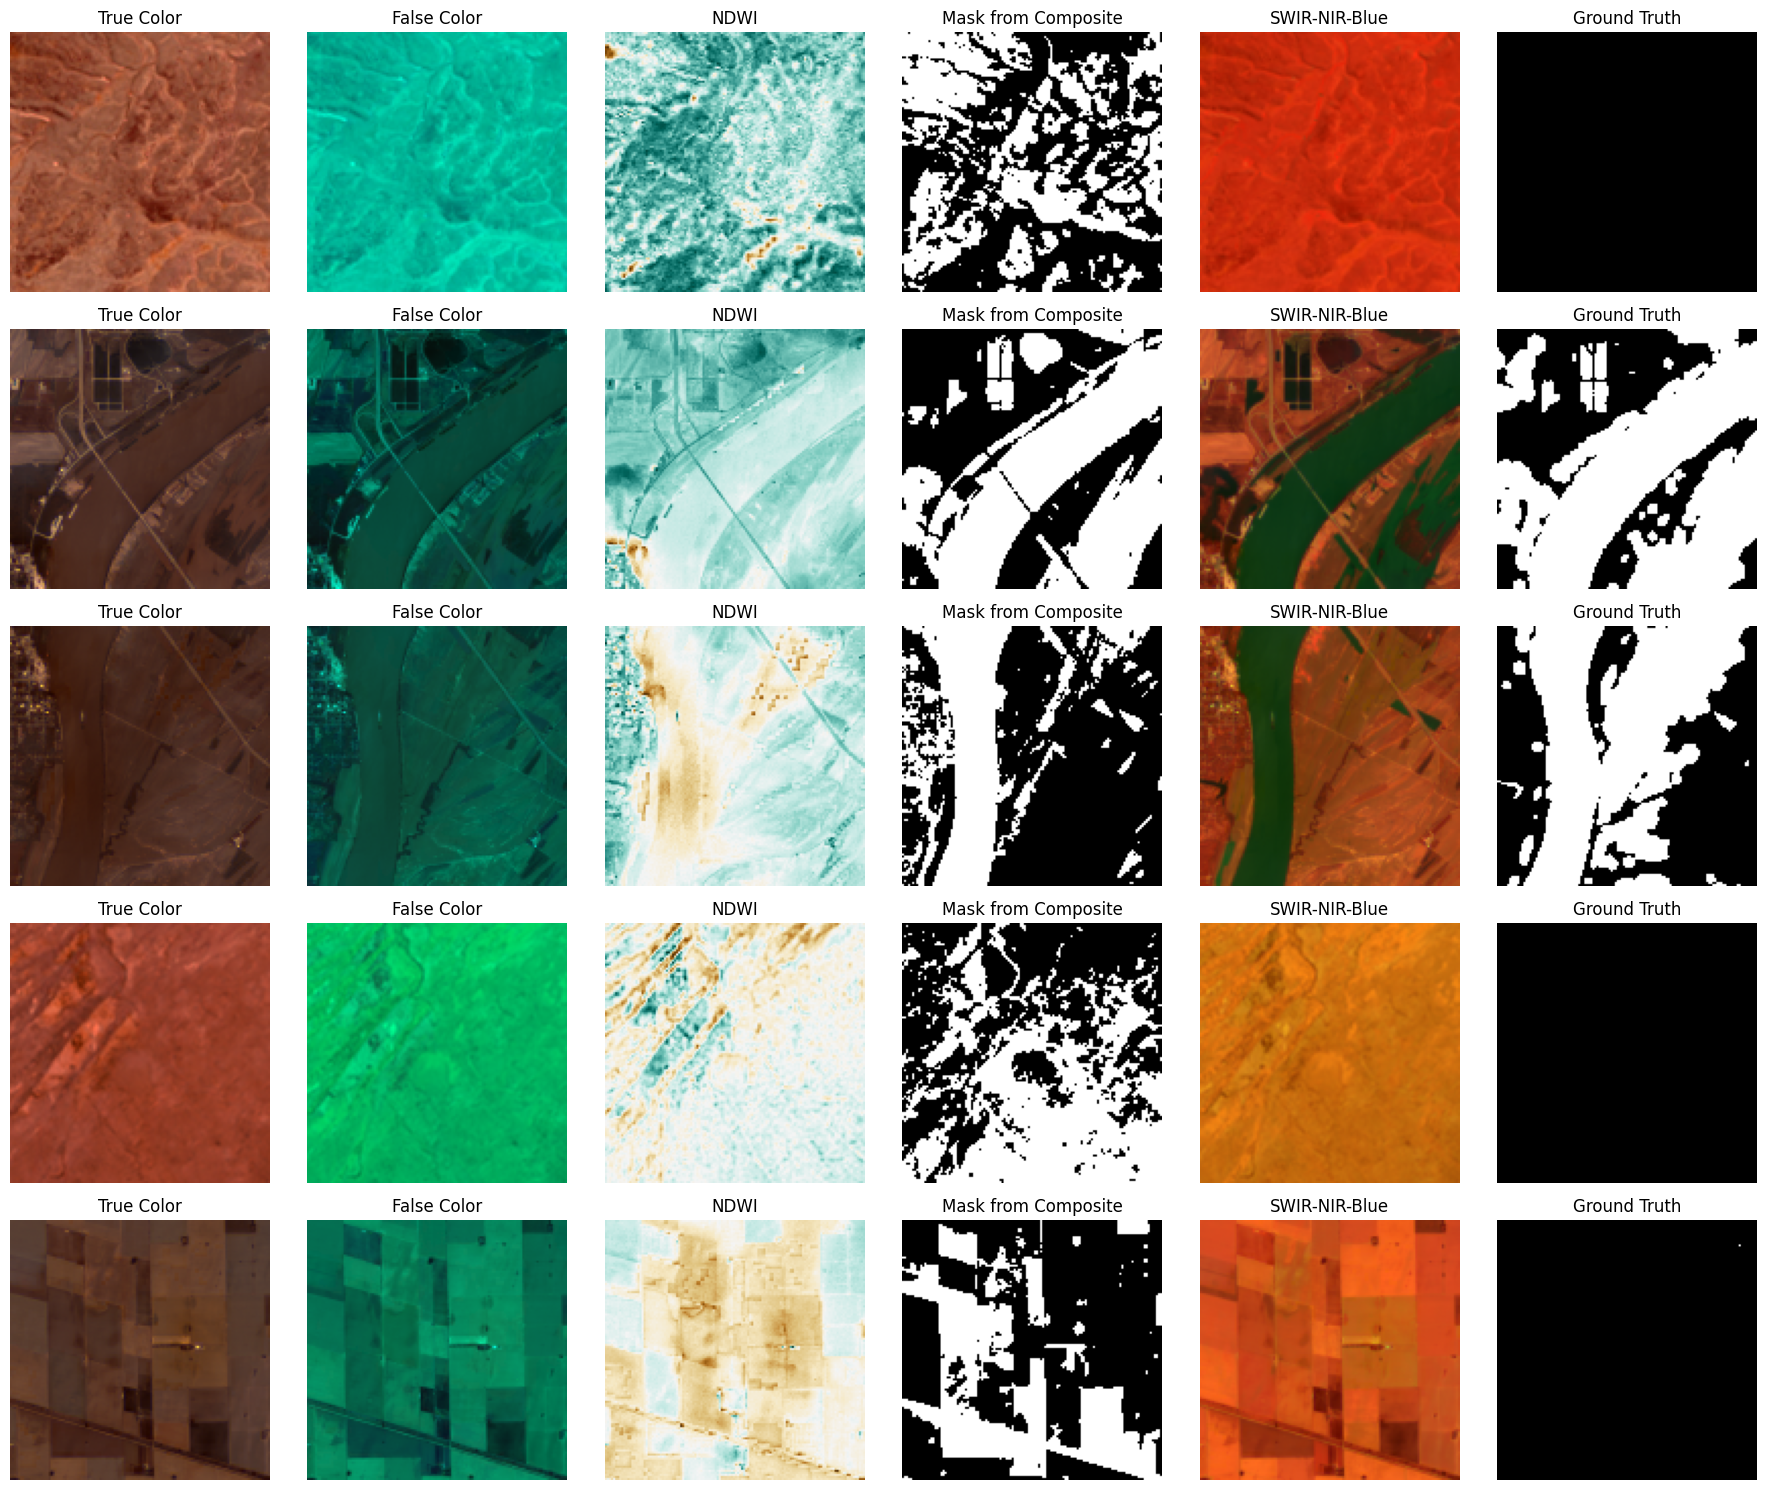

In [18]:
import os
import random
from glob import glob
import tifffile as tiff
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load paths
image_paths = sorted(glob("/content/drive/MyDrive/Water Segmentation/data/images/*.tif"))
label_paths = sorted(glob("/content/drive/MyDrive/Water Segmentation/data/labels/*.png"))

# Match by base filename
image_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
label_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in label_paths}
common_keys = sorted(set(image_dict.keys()) & set(label_dict.keys()))
matched_image_paths = [image_dict[k] for k in common_keys]
matched_label_paths = [label_dict[k] for k in common_keys]

# Random sample
num_samples = 5
random_indices = random.sample(range(len(matched_image_paths)), num_samples)

plt.figure(figsize=(18, num_samples * 3))

for row, idx in enumerate(random_indices):
    image = tiff.imread(matched_image_paths[idx])
    label = cv2.imread(matched_label_paths[idx], cv2.IMREAD_GRAYSCALE)

    # ----- True Color -----
    rgb = image[:, :, [2, 1, 0]].astype(np.float32)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    plt.subplot(num_samples, 6, row * 6 + 1)
    plt.imshow(rgb)
    plt.title("True Color")
    plt.axis("off")

    # ----- False Color -----
    false_color = image[:, :, [7, 3, 2]].astype(np.float32)
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    plt.subplot(num_samples, 6, row * 6 + 2)
    plt.imshow(false_color)
    plt.title("False Color")
    plt.axis("off")

    # ----- NDWI -----
    green = image[:, :, 1].astype(np.float32)
    nir = image[:, :, 3].astype(np.float32)
    ndwi = (green - nir) / (green + nir + 1e-8)
    plt.subplot(num_samples, 6, row * 6 + 3)
    plt.imshow(ndwi, cmap='BrBG')
    plt.title("NDWI")
    plt.axis("off")

    # ----- Custom Mask from Blue + NIR + SWIR -----
    blue = image[:, :, 0].astype(np.float32)
    nir = image[:, :, 3].astype(np.float32)
    swir = image[:, :, 5].astype(np.float32)

    # Stack into RGB-like composite: R=SWIR, G=NIR, B=Blue
    composite = np.stack([swir, nir, blue], axis=2)
    composite_norm = (composite - composite.min()) / (composite.max() - composite.min() + 1e-8)

    # Convert to grayscale
    gray = composite_norm.mean(axis=2)

    # ----- RGB Composite (SWIR-NIR-Blue) -----
    composite_rgb = composite_norm
    plt.subplot(num_samples, 6, row * 6 + 5)
    plt.imshow(composite_rgb)
    plt.title("SWIR-NIR-Blue")
    plt.axis("off")


     # Apply threshold (can be tuned)
    threshold = np.mean(gray) - 0.1 * np.std(gray)
    custom_mask = gray < threshold  # you can flip to > if needed

    plt.subplot(num_samples, 6, row * 6 + 4)
    plt.imshow(custom_mask, cmap='gray')
    plt.title("Mask from Composite")
    plt.axis("off")

    # ----- Ground Truth -----
    plt.subplot(num_samples, 6, row * 6 + 6)
    plt.imshow(label, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [19]:
print("Image shape:", image.shape)
print("Label shape:", label.shape)

Image shape: (128, 128, 12)
Label shape: (128, 128)


In [ ]:
print("Unique label values:", np.unique(label))


Unique label values: [0 1]


In [22]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
import rasterio
import albumentations as A
from albumentations.pytorch import ToTensorV2

class WaterSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load multispectral image (shape: 12, H, W)
        with rasterio.open(self.image_paths[idx]) as src:
            image = src.read()  # shape: (12, H, W)

        # Load mask as grayscale (binary mask)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)  # shape: (H, W)
        mask = (mask > 0).astype(np.uint8)  # ensure binary 0 or 1

        # Transpose image to HWC for albumentations
        image = np.transpose(image, (1, 2, 0))  # shape: (H, W, 12)


        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']         # shape: (12, H, W) after ToTensorV2
            mask = augmented['mask'].unsqueeze(0)  # shape: (1, H, W)
        else:
            # Default fallback if no transform
            image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

        return image, mask


In [23]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomCrop(height=128, width=128, p=0.5),
    A.Normalize(),  # optional
    ToTensorV2()
])

In [24]:
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


image_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
label_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in label_paths}

common_keys = sorted(set(image_dict.keys()) & set(label_dict.keys()))

matched_images = [image_dict[k] for k in common_keys]
matched_labels = [label_dict[k] for k in common_keys]

print(f"Total matched pairs: {len(matched_images)}")




Total matched pairs: 306


In [25]:
from sklearn.model_selection import train_test_split

train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    matched_images, matched_labels, test_size=0.3, random_state=42
)

val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, random_state=42
)

print(f"Train: {len(train_imgs)} | Val: {len(val_imgs)} | Test: {len(test_imgs)}")

Train: 214 | Val: 46 | Test: 46


In [26]:
train_dataset = WaterSegmentationDataset(train_imgs, train_labels, transform=None)
val_dataset   = WaterSegmentationDataset(val_imgs, val_labels, transform=None)
test_dataset  = WaterSegmentationDataset(test_imgs, test_labels, transform=None)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [27]:
image_tensor, mask_tensor = train_dataset[0]

print("Image shape:", image_tensor.shape)
print("Mask shape :", mask_tensor.shape)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image shape: torch.Size([12, 128, 128])
Mask shape : torch.Size([1, 128, 128])


In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

In [30]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device).float()

        # التمرير الأمامي
        outputs = model(images)
        loss = criterion(outputs, masks)

        # التمرير الخلفي والتحديث
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [31]:
from sklearn.metrics import f1_score

def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    total_iou = 0
    total_acc = 0
    total_f1 = 0
    num_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Apply sigmoid then threshold
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            # Flatten predictions and masks
            preds_flat = preds.view(-1).cpu()
            masks_flat = masks.view(-1).cpu()

            # IoU
            intersection = (preds_flat * masks_flat).sum()
            union = preds_flat.sum() + masks_flat.sum() - intersection
            iou = (intersection / union).item() if union > 0 else 0
            total_iou += iou

            # Accuracy
            correct = (preds_flat == masks_flat).sum().item()
            total = masks_flat.numel()
            acc = correct / total
            total_acc += acc

            # F1 Score
            f1 = f1_score(masks_flat.numpy(), preds_flat.numpy(), zero_division=1)
            total_f1 += f1

            num_batches += 1

    avg_loss = val_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_acc = total_acc / num_batches
    avg_f1 = total_f1 / num_batches

    return avg_loss, avg_iou, avg_acc, avg_f1


In [32]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """[Conv2D => BatchNorm => ReLU] * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        # Bottleneck
        bn = self.bottleneck(self.pool4(d4))

        # Decoder
        up1 = self.up1(bn)
        up1 = torch.cat([up1, d4], dim=1)
        dec1 = self.dec1(up1)

        up2 = self.up2(dec1)
        up2 = torch.cat([up2, d3], dim=1)
        dec2 = self.dec2(up2)

        up3 = self.up3(dec2)
        up3 = torch.cat([up3, d2], dim=1)
        dec3 = self.dec3(up3)

        up4 = self.up4(dec3)
        up4 = torch.cat([up4, d1], dim=1)
        dec4 = self.dec4(up4)

        return self.final_conv(dec4)  # raw logits


In [33]:
from rasterio.errors import NotGeoreferencedWarning
import warnings

# Suppress NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=12, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 50

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Eval → IoU: {val_iou:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")



Epoch 1/50


100%|██████████| 54/54 [01:27<00:00,  1.62s/it]


Train Loss: 0.4293 | Val Loss: 0.3303
Eval → IoU: 0.6191 | Acc: 0.8978 | F1: 0.7565

Epoch 2/50


100%|██████████| 54/54 [00:06<00:00,  8.26it/s]


Train Loss: 0.3708 | Val Loss: 0.3234
Eval → IoU: 0.6199 | Acc: 0.8994 | F1: 0.7570

Epoch 3/50


100%|██████████| 54/54 [00:06<00:00,  8.02it/s]


Train Loss: 0.3343 | Val Loss: 0.3007
Eval → IoU: 0.6375 | Acc: 0.9014 | F1: 0.7715

Epoch 4/50


100%|██████████| 54/54 [00:06<00:00,  7.77it/s]


Train Loss: 0.3346 | Val Loss: 0.2764
Eval → IoU: 0.6356 | Acc: 0.8990 | F1: 0.7697

Epoch 5/50


100%|██████████| 54/54 [00:06<00:00,  8.08it/s]


Train Loss: 0.3143 | Val Loss: 0.2938
Eval → IoU: 0.6363 | Acc: 0.9003 | F1: 0.7698

Epoch 6/50


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Train Loss: 0.3081 | Val Loss: 0.2682
Eval → IoU: 0.6462 | Acc: 0.9029 | F1: 0.7789

Epoch 7/50


100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


Train Loss: 0.2887 | Val Loss: 0.2570
Eval → IoU: 0.6592 | Acc: 0.9060 | F1: 0.7886

Epoch 8/50


100%|██████████| 54/54 [00:06<00:00,  7.92it/s]


Train Loss: 0.2873 | Val Loss: 0.2637
Eval → IoU: 0.6394 | Acc: 0.9029 | F1: 0.7728

Epoch 9/50


100%|██████████| 54/54 [00:06<00:00,  8.29it/s]


Train Loss: 0.2895 | Val Loss: 0.3044
Eval → IoU: 0.5652 | Acc: 0.8864 | F1: 0.7121

Epoch 10/50


100%|██████████| 54/54 [00:06<00:00,  7.93it/s]


Train Loss: 0.2717 | Val Loss: 0.2565
Eval → IoU: 0.6498 | Acc: 0.9051 | F1: 0.7796

Epoch 11/50


100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Train Loss: 0.2823 | Val Loss: 0.2421
Eval → IoU: 0.6577 | Acc: 0.9053 | F1: 0.7878

Epoch 12/50


100%|██████████| 54/54 [00:06<00:00,  8.04it/s]


Train Loss: 0.2618 | Val Loss: 0.2555
Eval → IoU: 0.6545 | Acc: 0.9020 | F1: 0.7842

Epoch 13/50


100%|██████████| 54/54 [00:06<00:00,  8.01it/s]


Train Loss: 0.2776 | Val Loss: 0.2578
Eval → IoU: 0.5928 | Acc: 0.8940 | F1: 0.7351

Epoch 14/50


100%|██████████| 54/54 [00:06<00:00,  8.32it/s]


Train Loss: 0.2675 | Val Loss: 0.2742
Eval → IoU: 0.5883 | Acc: 0.8933 | F1: 0.7279

Epoch 15/50


100%|██████████| 54/54 [00:06<00:00,  7.90it/s]


Train Loss: 0.2546 | Val Loss: 0.2587
Eval → IoU: 0.6012 | Acc: 0.8965 | F1: 0.7389

Epoch 16/50


100%|██████████| 54/54 [00:06<00:00,  8.42it/s]


Train Loss: 0.2574 | Val Loss: 0.2153
Eval → IoU: 0.6521 | Acc: 0.9075 | F1: 0.7821

Epoch 17/50


100%|██████████| 54/54 [00:06<00:00,  8.01it/s]


Train Loss: 0.2423 | Val Loss: 0.2535
Eval → IoU: 0.5893 | Acc: 0.8966 | F1: 0.7270

Epoch 18/50


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Train Loss: 0.2450 | Val Loss: 0.2803
Eval → IoU: 0.5715 | Acc: 0.8906 | F1: 0.7133

Epoch 19/50


100%|██████████| 54/54 [00:06<00:00,  8.02it/s]


Train Loss: 0.2544 | Val Loss: 0.3535
Eval → IoU: 0.5345 | Acc: 0.8851 | F1: 0.6786

Epoch 20/50


100%|██████████| 54/54 [00:08<00:00,  6.60it/s]


Train Loss: 0.2610 | Val Loss: 0.2633
Eval → IoU: 0.5824 | Acc: 0.8940 | F1: 0.7217

Epoch 21/50


100%|██████████| 54/54 [00:06<00:00,  8.27it/s]


Train Loss: 0.2368 | Val Loss: 0.2658
Eval → IoU: 0.6998 | Acc: 0.9190 | F1: 0.8194

Epoch 22/50


100%|██████████| 54/54 [00:06<00:00,  8.01it/s]


Train Loss: 0.2385 | Val Loss: 0.2263
Eval → IoU: 0.6440 | Acc: 0.9052 | F1: 0.7728

Epoch 23/50


100%|██████████| 54/54 [00:06<00:00,  8.09it/s]


Train Loss: 0.2407 | Val Loss: 0.2226
Eval → IoU: 0.6485 | Acc: 0.9070 | F1: 0.7762

Epoch 24/50


100%|██████████| 54/54 [00:06<00:00,  8.17it/s]


Train Loss: 0.2232 | Val Loss: 0.2144
Eval → IoU: 0.6581 | Acc: 0.9094 | F1: 0.7851

Epoch 25/50


100%|██████████| 54/54 [00:06<00:00,  7.91it/s]


Train Loss: 0.2184 | Val Loss: 0.2236
Eval → IoU: 0.6579 | Acc: 0.9093 | F1: 0.7841

Epoch 26/50


100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Train Loss: 0.2188 | Val Loss: 0.2097
Eval → IoU: 0.6598 | Acc: 0.9078 | F1: 0.7858

Epoch 27/50


100%|██████████| 54/54 [00:06<00:00,  7.98it/s]


Train Loss: 0.2084 | Val Loss: 0.1863
Eval → IoU: 0.7161 | Acc: 0.9239 | F1: 0.8317

Epoch 28/50


100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


Train Loss: 0.2049 | Val Loss: 0.2181
Eval → IoU: 0.6788 | Acc: 0.9142 | F1: 0.8028

Epoch 29/50


100%|██████████| 54/54 [00:06<00:00,  8.01it/s]


Train Loss: 0.2064 | Val Loss: 0.2310
Eval → IoU: 0.6785 | Acc: 0.9137 | F1: 0.8033

Epoch 30/50


100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


Train Loss: 0.2042 | Val Loss: 0.1977
Eval → IoU: 0.6785 | Acc: 0.9171 | F1: 0.8007

Epoch 31/50


100%|██████████| 54/54 [00:06<00:00,  8.25it/s]


Train Loss: 0.2129 | Val Loss: 0.2074
Eval → IoU: 0.6718 | Acc: 0.9110 | F1: 0.7971

Epoch 32/50


100%|██████████| 54/54 [00:06<00:00,  7.77it/s]


Train Loss: 0.2190 | Val Loss: 0.1981
Eval → IoU: 0.7158 | Acc: 0.9195 | F1: 0.8306

Epoch 33/50


100%|██████████| 54/54 [00:06<00:00,  8.31it/s]


Train Loss: 0.2145 | Val Loss: 0.2040
Eval → IoU: 0.6910 | Acc: 0.9131 | F1: 0.8105

Epoch 34/50


100%|██████████| 54/54 [00:06<00:00,  7.94it/s]


Train Loss: 0.1951 | Val Loss: 0.1995
Eval → IoU: 0.6973 | Acc: 0.9200 | F1: 0.8152

Epoch 35/50


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


Train Loss: 0.1931 | Val Loss: 0.1892
Eval → IoU: 0.7277 | Acc: 0.9234 | F1: 0.8387

Epoch 36/50


100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


Train Loss: 0.1807 | Val Loss: 0.2112
Eval → IoU: 0.6578 | Acc: 0.9122 | F1: 0.7809

Epoch 37/50


100%|██████████| 54/54 [00:06<00:00,  8.03it/s]


Train Loss: 0.1884 | Val Loss: 0.1916
Eval → IoU: 0.7075 | Acc: 0.9225 | F1: 0.8234

Epoch 38/50


100%|██████████| 54/54 [00:06<00:00,  8.30it/s]


Train Loss: 0.1834 | Val Loss: 0.2011
Eval → IoU: 0.6828 | Acc: 0.9174 | F1: 0.8050

Epoch 39/50


100%|██████████| 54/54 [00:06<00:00,  7.89it/s]


Train Loss: 0.1991 | Val Loss: 0.1869
Eval → IoU: 0.7364 | Acc: 0.9291 | F1: 0.8449

Epoch 40/50


100%|██████████| 54/54 [00:06<00:00,  8.43it/s]


Train Loss: 0.1768 | Val Loss: 0.1826
Eval → IoU: 0.7222 | Acc: 0.9281 | F1: 0.8340

Epoch 41/50


100%|██████████| 54/54 [00:06<00:00,  7.87it/s]


Train Loss: 0.1709 | Val Loss: 0.1760
Eval → IoU: 0.7432 | Acc: 0.9319 | F1: 0.8494

Epoch 42/50


100%|██████████| 54/54 [00:06<00:00,  8.03it/s]


Train Loss: 0.1735 | Val Loss: 0.1953
Eval → IoU: 0.6822 | Acc: 0.9184 | F1: 0.8009

Epoch 43/50


100%|██████████| 54/54 [00:06<00:00,  8.02it/s]


Train Loss: 0.1657 | Val Loss: 0.1824
Eval → IoU: 0.7252 | Acc: 0.9272 | F1: 0.8353

Epoch 44/50


100%|██████████| 54/54 [00:06<00:00,  7.84it/s]


Train Loss: 0.1552 | Val Loss: 0.1821
Eval → IoU: 0.7206 | Acc: 0.9243 | F1: 0.8324

Epoch 45/50


100%|██████████| 54/54 [00:06<00:00,  8.21it/s]


Train Loss: 0.1461 | Val Loss: 0.1793
Eval → IoU: 0.7168 | Acc: 0.9268 | F1: 0.8273

Epoch 46/50


100%|██████████| 54/54 [00:06<00:00,  7.92it/s]


Train Loss: 0.1581 | Val Loss: 0.1902
Eval → IoU: 0.7162 | Acc: 0.9256 | F1: 0.8274

Epoch 47/50


100%|██████████| 54/54 [00:08<00:00,  6.05it/s]


Train Loss: 0.1453 | Val Loss: 0.1861
Eval → IoU: 0.7229 | Acc: 0.9274 | F1: 0.8341

Epoch 48/50


100%|██████████| 54/54 [00:06<00:00,  7.74it/s]


Train Loss: 0.1582 | Val Loss: 0.1725
Eval → IoU: 0.7449 | Acc: 0.9288 | F1: 0.8513

Epoch 49/50


100%|██████████| 54/54 [00:06<00:00,  7.82it/s]


Train Loss: 0.1451 | Val Loss: 0.1796
Eval → IoU: 0.7483 | Acc: 0.9323 | F1: 0.8515

Epoch 50/50


100%|██████████| 54/54 [00:06<00:00,  8.22it/s]


Train Loss: 0.1369 | Val Loss: 0.1978
Eval → IoU: 0.7145 | Acc: 0.9257 | F1: 0.8279


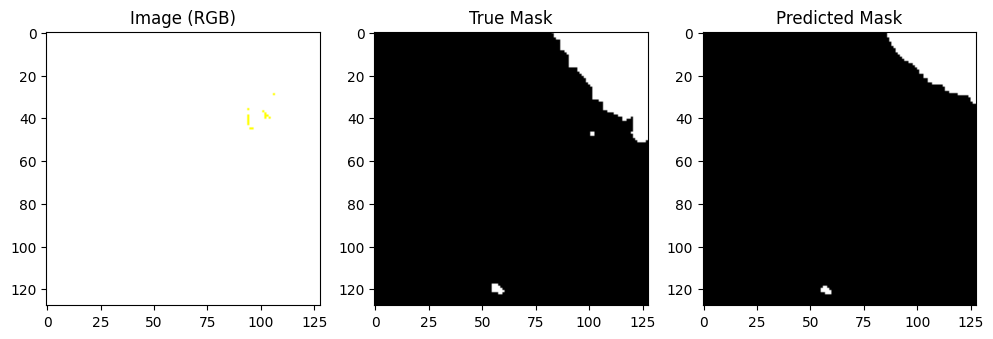

In [34]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        img = images[0][[3,2,1]].cpu().permute(1,2,0).numpy()  # RGB
        true_mask = masks[0][0].cpu().numpy()
        pred_mask = preds[0][0].cpu().numpy()

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.title("Image (RGB)"); plt.imshow(img)
        plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(true_mask, cmap='gray')
        plt.subplot(1,3,3); plt.title("Predicted Mask"); plt.imshow(pred_mask, cmap='gray')
        plt.show()
        break

In [35]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou


In [36]:
def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")


In [37]:
evaluate_metrics(model, test_loader, device)


=== Evaluation Metrics ===
Accuracy : 0.9284
Precision: 0.9592
Recall   : 0.7165
F1-Score : 0.8127
IoU      : 0.6947
